# 📚 | Import Libraries

In [1]:
import torch
import random
import math
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

# 📉 | Basic Calculus

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

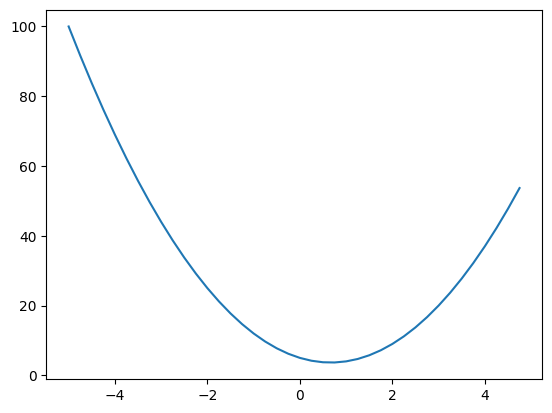

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Function response to a change (h)

In [5]:
h = 0.0001
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

# Building a Value object (micrograd)

In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self._label = _label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return -self.data

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        # other / self
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [7]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a * b; e._label = 'e'
d = e + c; d._label = 'd'
f = Value(-2.0, _label='f')
L = d * f; L._label = 'L'

In [8]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

# 📊 | GraphViz Utility

In [9]:
def trace(root):
    """Builds a set of all nodes and edges in a graph."""
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n._label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

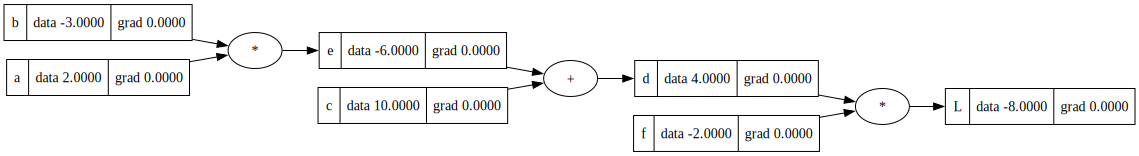

In [10]:
draw_dot(L)

In [11]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

### Activation Functions

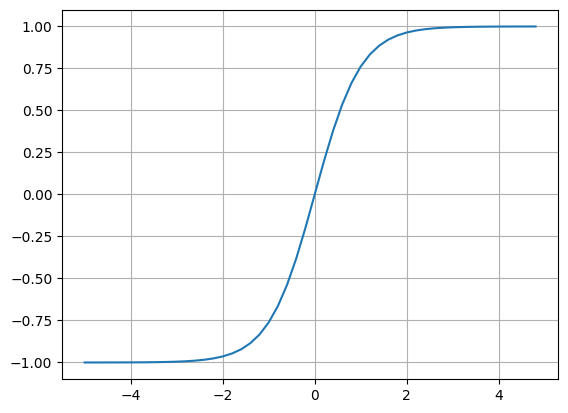

In [12]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [13]:
# Inputs x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')


# Weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, _label='b')

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n._label = 'n'

# Activation function
o = n.tanh(); o._label = 'o'

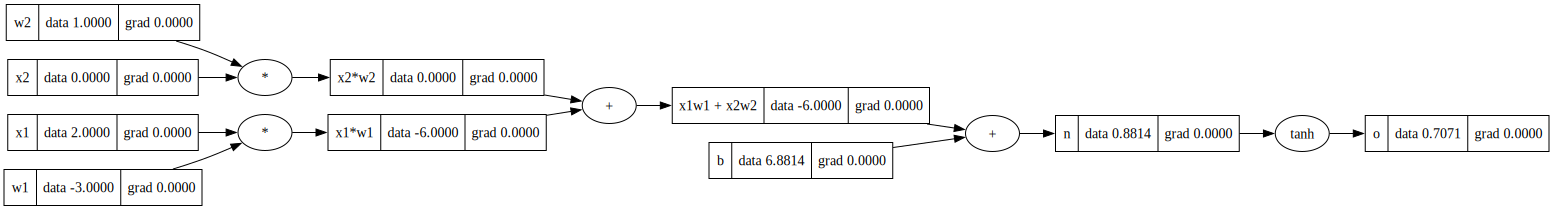

In [14]:
draw_dot(o)

In [15]:
o.backward()

In [16]:
o.grad = 1.0

In [17]:
o._backward()

In [18]:
n._backward()

In [19]:
b._backward()

In [20]:
x1w1x2w2._backward()

In [21]:
x1w1._backward()
x2w2._backward()

In [22]:
# Backpropagation
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [23]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2
# do/dn = 1 - o ** 2
1 - o.data ** 2

0.4999999999999999

# 🐛 | Backpropagation Bug

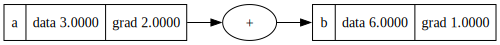

In [24]:
a = Value(3.0, _label='a')
b = a + a; b._label = 'b'
b.backward()
draw_dot(b)

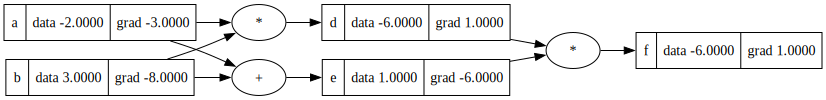

In [25]:
a = Value(-2.0, _label='a')
b = Value(3.0, _label='b')
d = a * b; d._label = 'd'
e = a + b; e._label = 'e'
f = d * e; f._label = 'f'

f.backward()
draw_dot(f)

In [26]:
b = 2
b.__mul__(3)

6

# 🛖 | Housekeeping

In [27]:
# Add int support for multiplication and addition
a * 2

Value(data=-4.0)

In [28]:
# Add support for divison
# a / b -> a * (1/b) -> a * (b**-1)

In [29]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [30]:
# Add subtraction support
# a + (-b)

In [31]:
a - b

Value(data=-2.0)

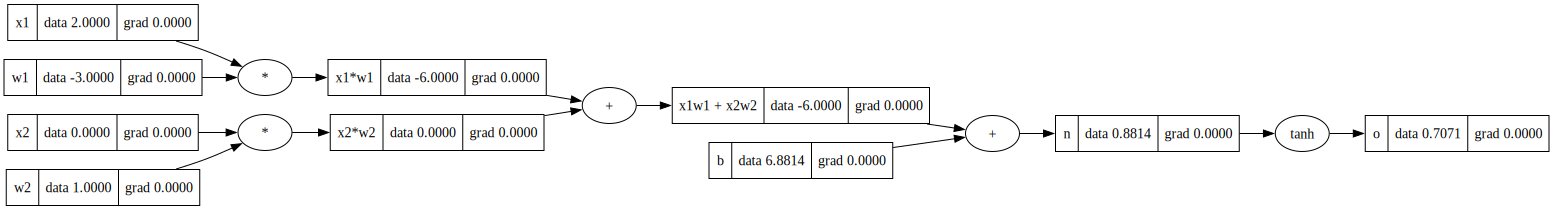

In [32]:
# Inputs x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')


# Weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, _label='b')

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n._label = 'n'

# Activation function
o = n.tanh(); o._label = 'o'
draw_dot(o)

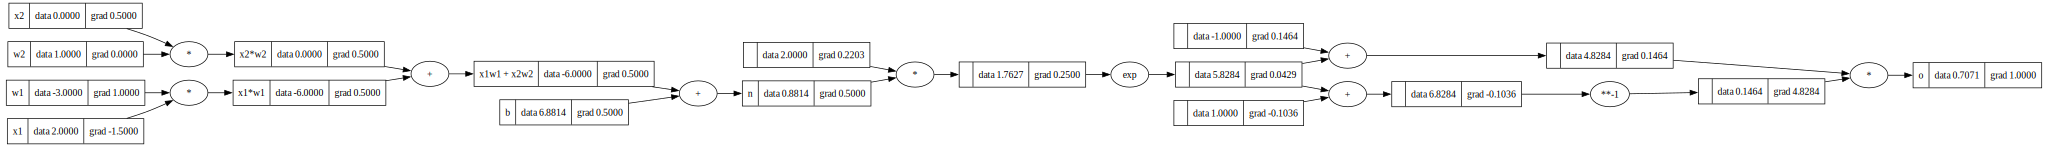

In [33]:
# Inputs x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')


# Weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, _label='b')

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n._label = 'n'

# Activation function
# o = n.tanh(); o._label = 'o'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o._label = 'o'
o.backward()
draw_dot(o)

# 🔦 | How about a modern deep learning package like Pytorch?

In [34]:
x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# 🧐 | Neuron

In [44]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1))  for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """w * x + b"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [45]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5363047777552845)

In [46]:
n.parameters()

[Value(data=0.8341769339797995),
 Value(data=-0.2595631172199244),
 Value(data=0.7031693518231739),
 Value(data=0.5969223190211581),
 Value(data=0.508886409940662),
 Value(data=-0.7036890793622821),
 Value(data=-0.8248548709808685),
 Value(data=0.7326635247504389),
 Value(data=0.6273500550249023),
 Value(data=-0.0026261707091355113),
 Value(data=0.043220521500222375),
 Value(data=0.7383706975062923),
 Value(data=0.6964269384864414),
 Value(data=0.9483605815818039),
 Value(data=-0.6391264788520294),
 Value(data=-0.8824527442010122),
 Value(data=0.36995970004798906),
 Value(data=-0.9953242587919588),
 Value(data=0.20933398844632323),
 Value(data=0.19377981255481092),
 Value(data=-0.7709201159390784),
 Value(data=0.5704043916937895),
 Value(data=0.6328861117469358),
 Value(data=-0.10490627020034071),
 Value(data=0.7522283186707899),
 Value(data=-0.2469249212343989),
 Value(data=-0.04579813902998864),
 Value(data=0.7926126349488711),
 Value(data=0.710400071141831),
 Value(data=-0.016613041

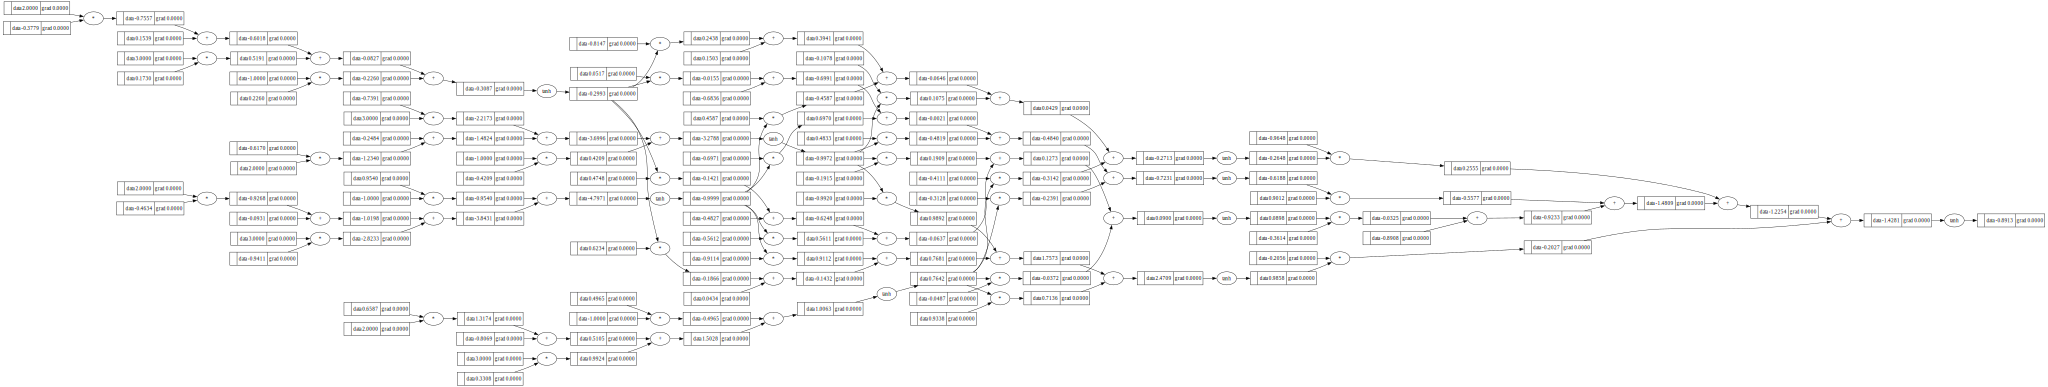

In [37]:
draw_dot(n(x))

# Tiny Dataset & Loss function

In [102]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [104]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6267181041219908)

In [109]:
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Zero grad
    for p in n.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.01579994862796615
1 0.015345202696205072
2 0.014915196585698525
3 0.014507990119966209
4 0.014121839256511937
5 0.013755172049014695
6 0.013406568045460178
7 0.013074740564469885
8 0.012758521392921805
9 0.012456847528790428
10 0.012168749658259714
11 0.011893342108901667
12 0.01162981406361933
13 0.011377421855118034
14 0.01113548218945349
15 0.010903366170928745
16 0.010680494020244246
17 0.010466330394115089
18 0.010260380228165859
19 0.010062185036291374


In [110]:
ypred

[Value(data=0.9610177704503933),
 Value(data=-0.9780911092872072),
 Value(data=-0.9331308029158396),
 Value(data=0.9400743643781081)]